In [1]:
import jax
import jax.numpy as jnp
from approx_post.distributions import approx, joint, mixture
from approx_post import losses, optimisers
import seaborn as sns
import matplotlib.pyplot as plt
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

In [2]:
def create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey):
    mean = model(true_theta)
    samples = jax.random.multivariate_normal(key=prngkey, mean=mean, cov=noise_cov, shape=(num_samples,))
    return samples.reshape(num_samples, -1)

In [3]:
# First, let's define a model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [4]:
# Create artificial data:
prngkey = jax.random.PRNGKey(10)
true_theta = jnp.array([2])
noise_cov = 1*jnp.identity(ndim)
num_samples = 1
data = create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey)
print(f'True theta: \n {true_theta}')
print(f'True x = model(theta): \n {model(true_theta)}')
print(f'Observations x_obs = model(theta) + noise: \n {data}')

True theta: 
 [2]
True x = model(theta): 
 [4]
Observations x_obs = model(theta) + noise: 
 [[2.6554594]]


In [5]:
# Create Gaussian approximate distribution:
approx_dist = approx.Gaussian(ndim)
mix_dist = mixture.Identical(approx_dist, 2)

In [6]:
phi = mix_dist.phi()
phi['component_0']['mean'] = jnp.array([[-1.]])
phi['component_0']['log_chol_diag'] = jnp.array([[-1.]])
phi['component_1']['mean'] = jnp.array([[1.]])
phi['component_1']['log_chol_diag'] = jnp.array([[-1.]])
phi['log_unnorm_coeff'] = jnp.array([0.1, 0.5])

In [7]:
mix_dist.update(phi)

In [8]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = 1.0*jnp.identity(ndim)
joint_dist = joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

In [9]:
approx_dist = approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = losses.SELBO(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(mix_dist, loss, data, prngkey, verbose = True, max_iter=1000, num_samples=1000)

Jaxtainer({'component_0': {'log_chol_diag': DeviceArray([1, 2, 1], dtype=int32), 'mean': DeviceArray([1, 2, 1], dtype=int32)}, 'component_1': {'log_chol_diag': DeviceArray([1, 2, 1], dtype=int32), 'mean': DeviceArray([1, 2, 1], dtype=int32)}, 'log_unnorm_coeff': DeviceArray([1, 2, 2], dtype=int32)})
(1, 1000, 2)
(1, 2)
Jaxtainer({'component_0': {'log_chol_diag': DeviceArray([   1, 1000,    1], dtype=int32), 'mean': DeviceArray([   1, 1000,    1], dtype=int32)}, 'component_1': {'log_chol_diag': DeviceArray([   1, 1000,    1], dtype=int32), 'mean': DeviceArray([   1, 1000,    1], dtype=int32)}, 'log_unnorm_coeff': DeviceArray([   1, 1000,    2], dtype=int32)})


ValueError: Incompatible shapes for broadcasting: ((1, 1000, 2, 1), (1, 1, 1000, 2))

In [ ]:
def plot_posteriors(approx_dist, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    pdf = jnp.exp(approx_dist.logpdf(theta))
    ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze())
    ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("Posterior Probability Density")

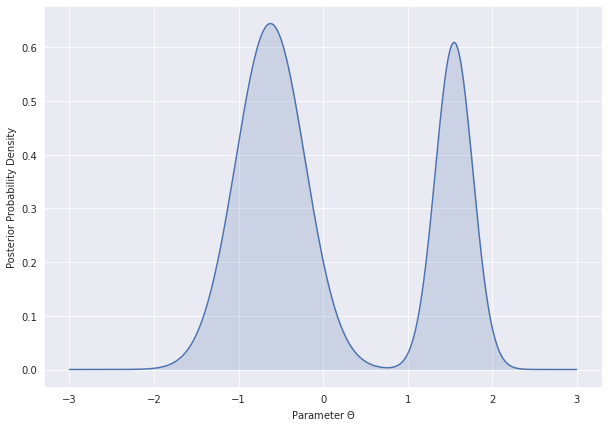

In [22]:
plot_posteriors(mix_dist)

In [23]:
mix_dist.phi()

Jaxtainer({'component_0': {'mean': DeviceArray([[-0.6221581]], dtype=float32), 'log_chol_diag': DeviceArray([[-0.8934846]], dtype=float32)}, 'component_1': {'mean': DeviceArray([[1.5500113]], dtype=float32), 'log_chol_diag': DeviceArray([[-1.5037557]], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([[ 0.05372816, -0.6125946 ]], dtype=float32)})

In [25]:
jnp.exp(0.05)

DeviceArray(1.0512711, dtype=float32, weak_type=True)

In [26]:
jnp.exp(-0.61)

DeviceArray(0.5433509, dtype=float32, weak_type=True)